In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from DAFD.rv_study.rv_utils import *
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from DAFD.helper_scripts.ModelHelper import ModelHelper
from sklearn.feature_selection import f_regression


Using TensorFlow backend.


regime classifier
Loading classifier
Train accuracy: 0.9887387387387387

Regression model generation_rate2
Loading Regressor
R square (R^2) for Train:                 0.987384

Regression model droplet_size2
Loading Regressor
R square (R^2) for Train:                 0.983142

Regression model generation_rate1
Loading Regressor
R square (R^2) for Train:                 0.965872

Regression model droplet_size1
Loading Regressor
R square (R^2) for Train:                 0.953238



In [2]:
# Load robustness results
all_results = pd.read_csv("data/20210423_robustness_designspace.csv")

# Filter robustness results
all_results = all_results.loc[all_results.loc[:,"generation_rate"] > 5, :]
all_results = all_results.loc[all_results.loc[:,"generation_rate"] < 500, :]
all_results = all_results.loc[all_results.loc[:,"droplet_size"] > 25, :]
all_results = all_results.loc[all_results.loc[:,"droplet_size"] < 250, :]
all_results = all_results.loc[all_results.loc[:,"regime"] == 1, :]
all_results = all_results.loc[all_results.loc[:,"capillary_number"] < .28, :]

Main-effect Analysis

In [3]:
# Calculate averages to normalize by in plots
mean_score = all_results["score_flow"].mean()
mean_size_score = all_results["size_score_flow"].mean()
mean_rate_score = all_results["rate_score_flow"].mean()

In [4]:
# Perform Main Effect analysis on all results
meff_cols = ['aspect_ratio', 'expansion_ratio',
       'normalized_oil_inlet', 'normalized_orifice_length',
       'normalized_water_inlet', 'orifice_size', "capillary_number", "flow_rate_ratio"]

meff_vals = {}
for col in meff_cols:
    sweep_range = np.sort(all_results[col].unique())
    size_score_avgs = []
    rate_score_avgs = []
    score_avgs = []
    size_score_std = []
    rate_score_std = []
    score_std = []
    
    
    
    for val in sweep_range:
        #size_avgs.append(size_normalized[all_results[col] == val].mean())
        size_score_avgs.append(all_results.loc[all_results[col] == val, "size_score_flow"].mean())
        rate_score_avgs.append(all_results.loc[all_results[col] == val, "rate_score_flow"].mean())
        score_avgs.append(all_results.loc[all_results[col] == val, "score_flow"].mean())
        size_score_std.append(all_results.loc[all_results[col] == val, "size_score_flow"].std())
        rate_score_std.append(all_results.loc[all_results[col] == val, "rate_score_flow"].std())
        score_std.append(all_results.loc[all_results[col] == val, "score_flow"].std())

        
        #meff_vals[col] = {"range": sweep_range, "size_averages": size_avgs, "rate_averages": rate_avgs}
    meff_vals[col] = {"range": sweep_range, "size_score_avgs": size_score_avgs, "rate_score_avgs": rate_score_avgs, "score_avgs": score_avgs,
                      "size_score_std": size_score_std, "rate_score_std":rate_score_std, "score_std":score_std}
    

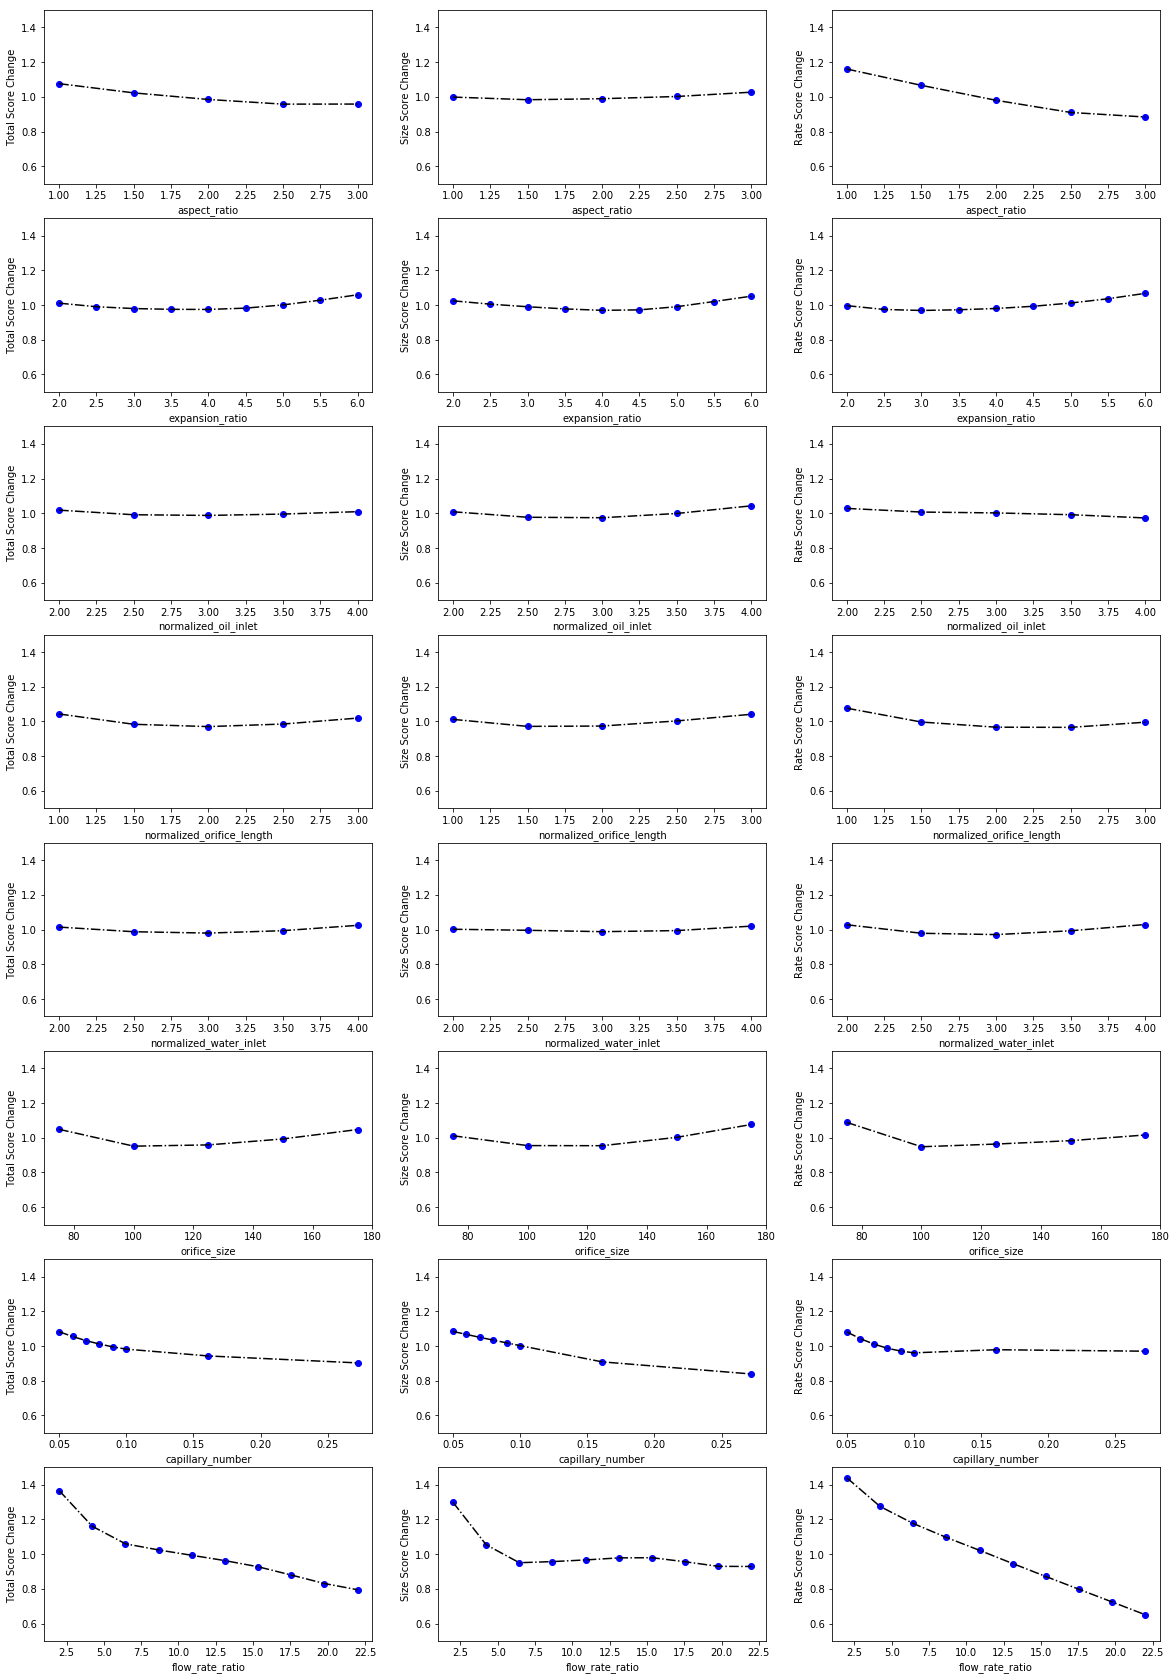

In [5]:
# Plot all 
fig, axs = plt.subplots(8,3, figsize=[20,30])

for i, param in enumerate(meff_vals.keys()):
    mean_score = np.mean(meff_vals[param]["score_avgs"])
    mean_size_score = np.mean(meff_vals[param]["size_score_avgs"])
    mean_rate_score = np.mean(meff_vals[param]["rate_score_avgs"])
    
    param_range = meff_vals[param]["range"]
    score_normed =  meff_vals[param]["score_avgs"]/mean_score
    size_score_normed = meff_vals[param]["size_score_avgs"]/mean_size_score
    rate_score_normed = meff_vals[param]["rate_score_avgs"]/mean_rate_score
    
    score_std_normed =  meff_vals[param]["score_std"]/mean_score
    size_score_std_normed = meff_vals[param]["size_score_std"]/mean_size_score
    rate_score_std_normed = meff_vals[param]["rate_score_std"]/mean_rate_score
    
    
    
    axs[i][0].plot(param_range, score_normed,"bo")
    #axs[i][0].errorbar(param_range, score_normed, yerr=score_std_normed, fmt="bo", ecolor="k", capsize=5)
    axs[i][0].plot(param_range, score_normed, "k-.")
    
    axs[i][0].set_xlabel(param)
    axs[i][0].set_ylabel("Total Score Change")
    axs[i][0].set_ylim([0.5, 1.5])
        
    #axs[i][1].errorbar(param_range, size_score_normed, yerr=size_score_std_normed, fmt="bo", ecolor="k", capsize=5)
    axs[i][1].plot(param_range, size_score_normed,"bo")
    axs[i][1].plot(param_range, size_score_normed, "k-.")
    
    axs[i][1].set_xlabel(param)
    axs[i][1].set_ylabel("Size Score Change")
    axs[i][1].set_ylim([0.5, 1.5])
    
    #axs[i][2].errorbar(param_range, rate_score_normed, yerr=rate_score_std_normed, fmt="bo", ecolor="k", capsize=5)
    axs[i][2].plot(param_range, rate_score_normed,"bo")
    axs[i][2].plot(param_range, rate_score_normed, "k-.")

    axs[i][2].set_xlabel(param)
    axs[i][2].set_ylabel("Rate Score Change")
    axs[i][2].set_ylim([0.5, 1.5])
    
##plt.savefig('Robust_MainEffect_Dripping.png')

Run F-regression to quantify versatility score sensitivity to parameter changes

In [6]:
X = np.zeros([all_results.shape[0], len(meff_cols)])
for i, col in enumerate(meff_cols):
    X[:,i] = all_results.loc[:, col]
Y = all_results.loc[:, "score_fab"]
f_test_all, _ = f_regression(X,all_results.loc[:, "score_fab"])
f_test_size, _ = f_regression(X,all_results.loc[:, "size_score_fab"])
f_test_rate, _ = f_regression(X,all_results.loc[:, "rate_score_fab"])
F = pd.DataFrame([f_test_all, f_test_size, f_test_rate], columns=meff_cols, index=["score_fab", "size_score_fab", "rate_score_fab"])